In [1]:
import numpy as np
import pandas as pd
from numpy import sqrt 
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
x = pd.read_csv("C:/Users/oQaris/Desktop/QLab/trainData/all.csv")
y = x['our_gp']
del x['our_gp']

In [3]:
x.loc[0]

lvl1      0.000000
lvl2      0.000000
lvl3      0.000000
lvl4      0.000000
lvl5      0.000000
lvl6      0.000000
lvl7      1.000000
lvl8      0.000000
lvl9      0.000000
lvl10     0.000000
p0_e      0.235669
p0_a      0.178344
p0_r      0.033263
p0_s      0.000708
p0_gc     0.847648
p0_gp     0.214447
vr0       0.171267
gc0       4.826897
p0_opp    1.000000
p0_our    0.000000
p1_e      0.287033
p1_a      0.212725
p1_r      0.037882
p1_s      0.014085
p1_gc    -0.659423
p1_gp    -0.090885
vr1       0.220010
gc1      -0.372043
p1_opp    0.000000
p1_our    1.000000
p2_e      0.250388
p2_a      0.202748
p2_r      0.041214
p2_s      0.003324
p2_gc     0.655856
p2_gp     0.203764
vr2       0.200753
gc2       0.280091
p2_opp    1.000000
p2_our    0.000000
p3_e      0.269981
p3_a      0.204948
p3_r      0.035607
p3_s      0.012994
p3_gc     1.781590
p3_gp     0.170647
vr3       0.201671
gc3       2.806248
p3_opp    0.000000
p3_our    1.000000
Name: 0, dtype: float64

In [4]:
y

0         1.646007
1         0.036192
2         0.082518
3         0.082518
4        -0.056459
            ...   
181403   -0.010133
181404   -0.102785
181405   -0.010133
181406   -0.334413
181407    0.267820
Name: our_gp, Length: 181408, dtype: float64

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
x_train.shape, y_train.shape

((145126, 50), (145126,))

**Нейронка**

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# Размерность нейросети
n_input = x.loc[0].size
n_hiden = n_input*2-1
n_input, n_hiden

(50, 99)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cnn = nn.Sequential(
            nn.Linear(n_input, n_hiden),
            nn.ReLU(),
            nn.Linear(n_hiden, n_hiden),
            nn.ReLU(),
            nn.Linear(n_hiden, n_hiden),
            nn.ReLU(),
            nn.Linear(n_hiden, 1)
        )

    def init_optimizer(self, lr=3e-3):
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        return self.cnn(x)
      

loss_fn = torch.nn.L1Loss() #reduction='sum'

In [9]:
# Нормализация
sc = StandardScaler()
#sc.fit(x) надо ли искать среднее и дисперсию по всему набору?
x_train = sc.fit_transform(x_train)
x_test  = sc.transform(x_test)

x_train[1]

array([-0.04420226, -0.16221741,  1.58078046, -0.44077837, -0.42424299,
       -0.57756775, -0.34248979, -0.11493108, -0.05438644, -0.0168105 ,
        0.10794612,  0.39029459, -0.04221868,  0.38407169,  0.91382897,
        0.20672307,  0.3158226 , -0.49100901, -1.05428041,  1.05428041,
       -0.5326174 ,  0.08108138,  0.11948902, -1.11528653,  0.0852498 ,
        0.07317222, -0.66980255,  0.22438511,  0.9848589 , -0.9848589 ,
        1.15168812,  0.602564  , -0.35198036,  1.80916521,  0.68512458,
       -0.31698592,  0.60310146,  0.92313521,  1.40738569, -0.60436921,
        1.65029613,  1.84301181,  1.35869224,  1.55622998,  2.13343971,
        1.41707371,  1.87966703,  1.01982412, -0.36598836,  2.72871872])

In [10]:
# Создаём датасеты
batch_size = 100

train_dataset = TensorDataset(torch.tensor(np.array(x_train)).float(), torch.tensor(np.array(y_train)).float())
test_dataset  = TensorDataset(torch.tensor(np.array(x_test)).float(), torch.tensor(np.array(y_test)).float())

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_dataset, batch_size=batch_size)

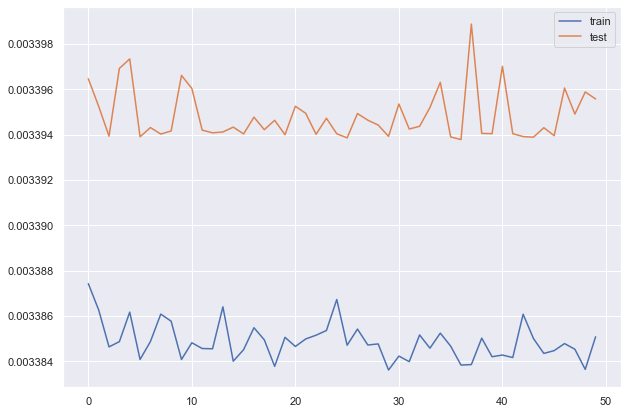

In [11]:
# Обучаем
net = Net().to(device)
net.init_optimizer()

epochs = 50
train_losses = []
test_losses  = []

for eph in tqdm(range(epochs)):
    n = 0
    train_loss = 0
    test_loss = 0
    
    for x, y in train_dl:
        x = x.to(device)
        y = y.to(device)
        
        # обнуляем градиент
        net.opt.zero_grad()
        # предсказываем
        pred = net.forward(x)
        # считаем ошибку
        loss = loss_fn(pred, y)
        loss.backward()
        net.opt.step()
        train_loss += loss
        
    train_losses.append(train_loss.detach().cpu() / len(x_train))
        
    for x, y in test_dl:
        x = x.to(device)
        y = y.to(device)
        pred = net.forward(x)
        loss = loss_fn(pred, y)
        test_loss += loss
        
    test_losses.append(test_loss.detach().cpu() / len(x_test))
    
    # Выводим график
    clear_output()
    sns.set(rc={'figure.figsize':(10,7)})
    sns.lineplot(x=np.arange(0,len(train_losses)),y=np.array(train_losses),label='train')
    sns.lineplot(x=np.arange(0,len(test_losses)),y=np.array(test_losses),label='test')
    plt.show()

In [12]:
# Это наверное уже не надо, раз есть график выше, но по сути тут должно на валидационной выборке запускаться
loss_norm=0
loss=0
gr_loss = 0
ls_loss = 0

with torch.no_grad():
    for x, y in train_dl:
        x = x.to(device)
        y = y.to(device)
        pred = net.forward(x)
        loss = loss + loss_fn(pred, y)
        if pred > y:
            gr_loss += 1
        elif output < target:
            ls_loss += 1

print(loss/len(x_test))
print(len(x_test))
print(gr_loss*100/len(x_test))
print(ls_loss*100/len(x_test))

C:\Users\oQaris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [13]:
# Сохраняем модель
torch.onnx.export(net.to(torch.float32),               
                  torch.randn(n_input).to(torch.float32).to(device),                         
                  "Qlab.onnx",
                  input_names = ['input_1'])